# Trabajo Final Aprendizaje de Máquinas - Marino, Musciano, Uribe

La medición precisa de la grasa corporal es inconveniente/costosa y es deseable disponer de métodos sencillos para estimar la grasa corporal que no sean inconvenientes/costosos. Con este dataset de 252 hombres se busca predecir el porcentaje de grasa corporal (BodyFat) determinado mediante el cálculo de la densidad del cuerpo (Density), en base a diferentes mediciones corporales.

Link al dataset: https://www.kaggle.com/datasets/fedesoriano/body-fat-prediction-dataset/

## Propuesta de investigación

La medición precisa de la grasa corporal es inconveniente/costosa y es deseable disponer de métodos sencillos para estimar la grasa corporal que no sean inconvenientes/costosos. Con este dataset de 252 hombres se busca predecir el porcentaje de grasa corporal (BodyFat) determinado mediante el cálculo de la densidad del cuerpo (Density), en base a diferentes mediciones corporales.

Link al dataset: https://www.kaggle.com/datasets/fedesoriano/body-fat-prediction-dataset/


## Análisis del Dataset

In [1]:
# Importamos librerías básicas
import pandas as pd
import numpy as np
import matplotlib as plt
import seaborn as sns

# Prefiero los colores oscuros en los gráficos
sns.set(rc={
    'axes.facecolor': 'black',
    'figure.facecolor': 'black',
    'axes.labelcolor': 'white',
    'xtick.color': 'cyan',
    'ytick.color': 'white',
    'axes.titlecolor': 'white'
})


df = pd.read_csv("data/bodyfat.csv")

# Pasamos el peso a kilogramos y la altura a metros para mayor legibilidad
df['Weight'] = df['Weight'] * 0.453592
df['Height'] = df['Height'] * 0.0254

# Nos deshacemos de la columna Density (está estrechamente relacionada con BodyFat
# a través de la ecuación de Siri ( %Body Fat = (495 / Body Density) - 450 ) como dice 
# el diccionario de datos, y es dificil de obtener, por lo que quisieramos un modelo que
# no requiera ese input).

df.drop(columns='Density',inplace=True)

Procedamos a observar la salud del dataset (sus nulos y si necesita algún encoding)

In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 252 entries, 0 to 251
Data columns (total 14 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   BodyFat  252 non-null    float64
 1   Age      252 non-null    int64  
 2   Weight   252 non-null    float64
 3   Height   252 non-null    float64
 4   Neck     252 non-null    float64
 5   Chest    252 non-null    float64
 6   Abdomen  252 non-null    float64
 7   Hip      252 non-null    float64
 8   Thigh    252 non-null    float64
 9   Knee     252 non-null    float64
 10  Ankle    252 non-null    float64
 11  Biceps   252 non-null    float64
 12  Forearm  252 non-null    float64
 13  Wrist    252 non-null    float64
dtypes: float64(13), int64(1)
memory usage: 27.7 KB


No hay valores nulos, y afortunadamente todas las variables son numéricas (como nos interesa hacer una regresión, las categóricas hubiesen tenido que ser codificadas de alguna manera).

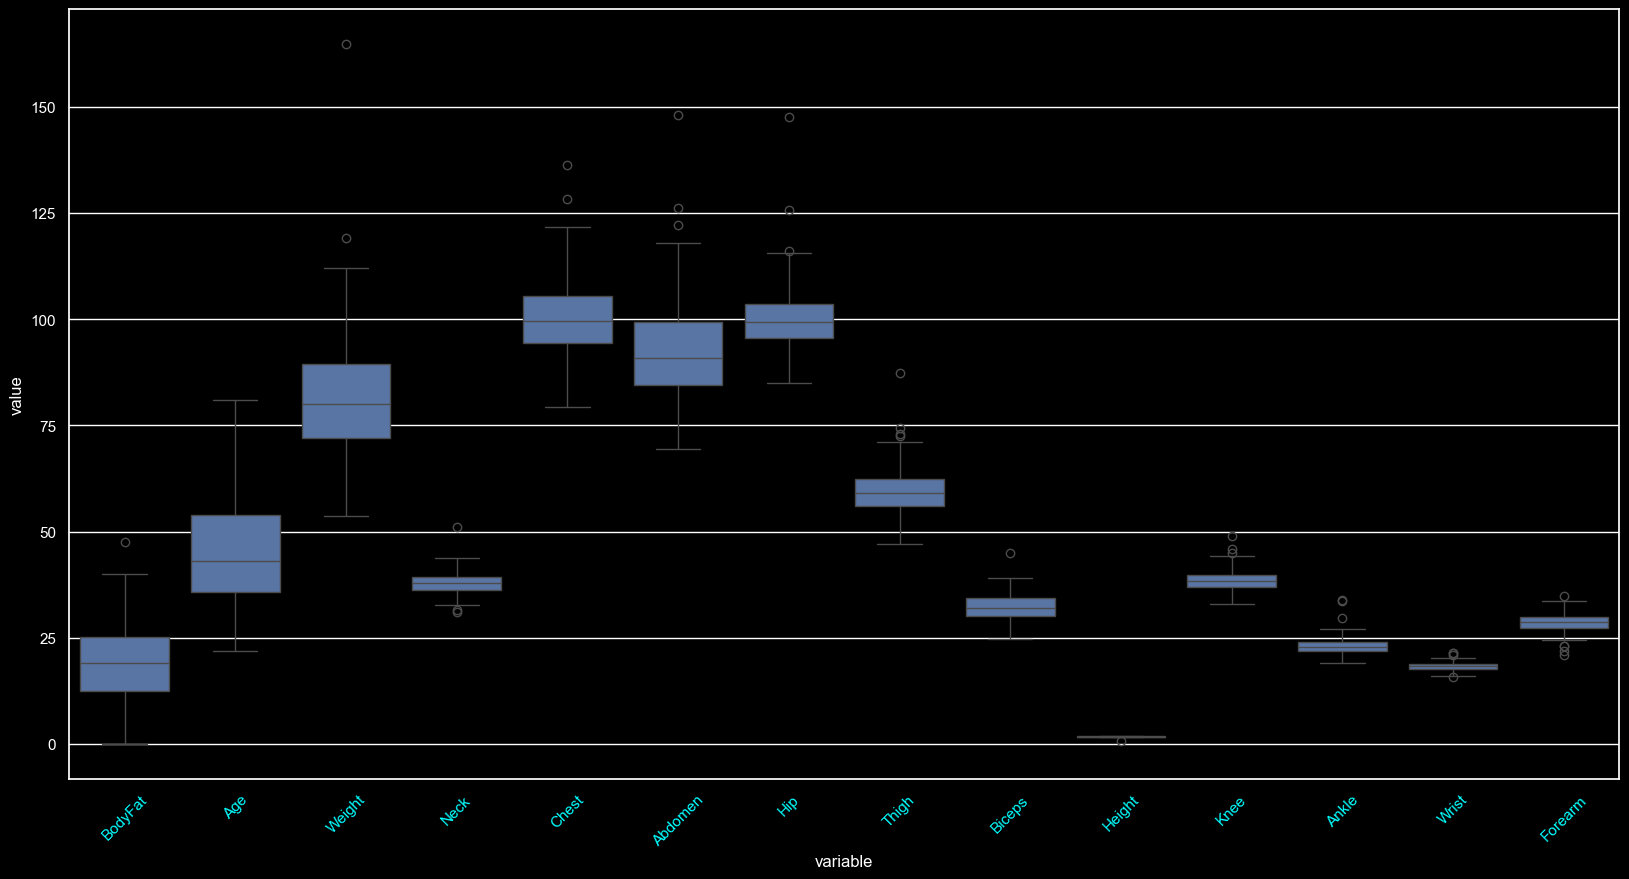

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

column = ['BodyFat', 'Age', 'Weight', 'Neck', 'Chest', 'Abdomen', 'Hip',
       'Thigh',  'Biceps','Height','Knee','Ankle','Wrist','Forearm']

df_melted = df.melt(value_vars=column)

# Crear boxplot
plt.figure(figsize=(20, 10))
sns.boxplot(x='variable', y='value', data=df_melted)

# Ajustar rotación de etiquetas para mejor visualización
plt.xticks(rotation=45)

# Mostrar gráfico
plt.show()


A continuación, analizaremos el carácter normal del dataset:

array([[<Axes: title={'center': 'BodyFat'}>,
        <Axes: title={'center': 'Age'}>,
        <Axes: title={'center': 'Weight'}>,
        <Axes: title={'center': 'Height'}>,
        <Axes: title={'center': 'Neck'}>],
       [<Axes: title={'center': 'Chest'}>,
        <Axes: title={'center': 'Abdomen'}>,
        <Axes: title={'center': 'Hip'}>,
        <Axes: title={'center': 'Thigh'}>,
        <Axes: title={'center': 'Knee'}>],
       [<Axes: title={'center': 'Ankle'}>,
        <Axes: title={'center': 'Biceps'}>,
        <Axes: title={'center': 'Forearm'}>,
        <Axes: title={'center': 'Wrist'}>, <Axes: >]], dtype=object)

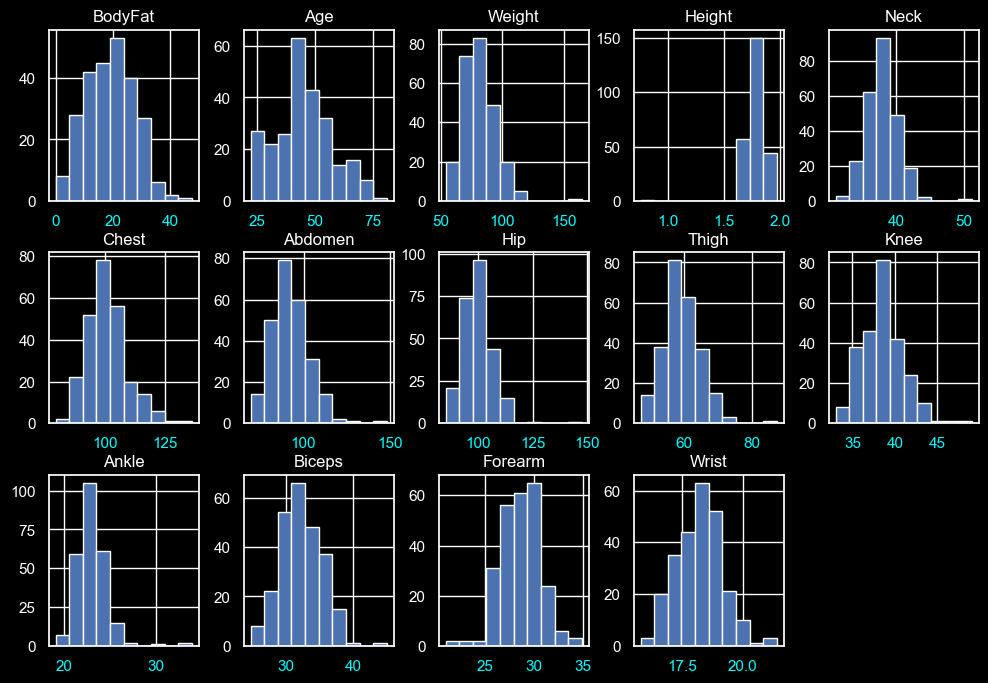

In [4]:
df.hist(figsize=(12, 8), layout=(3, 5))

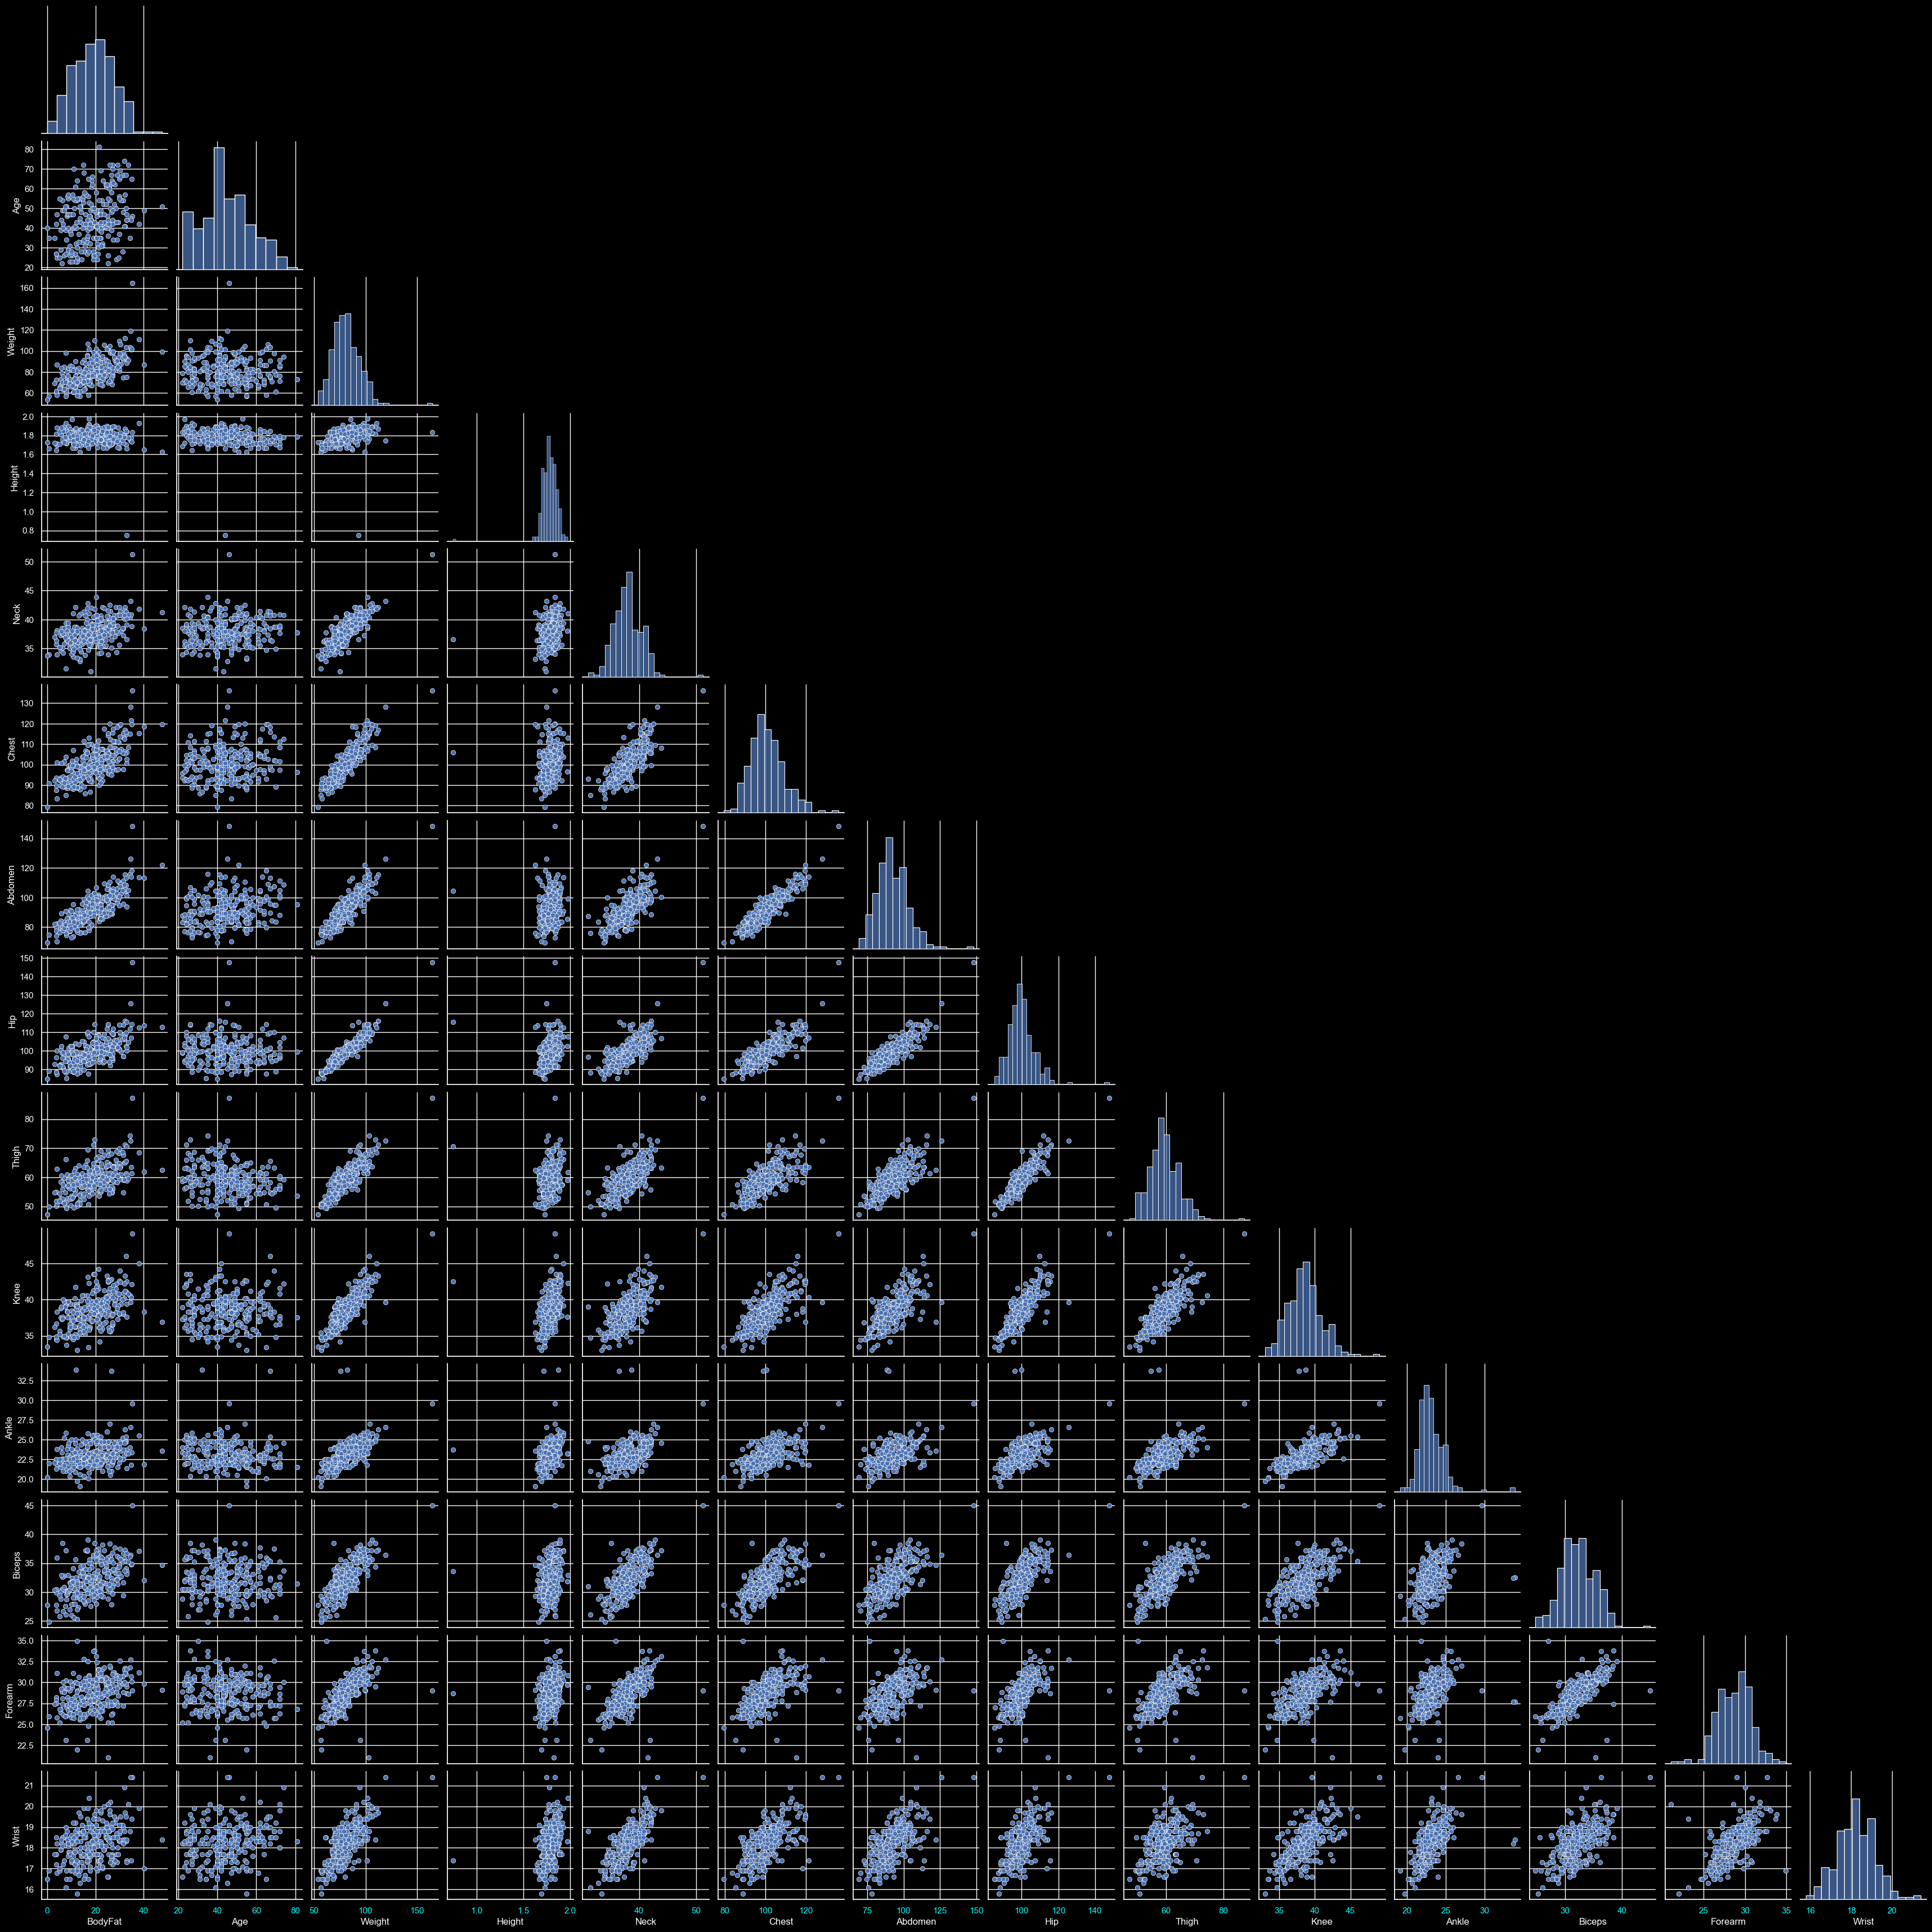

In [5]:
sns.pairplot(df, corner = True)

En los histogramas, podemos oservar que nuestro dataset posee outliers. Para manejarlos de una manera sencilla, probemos simplemente con eliminarlos.

Utilizaremos un análisis de Z-Scoring para señalar esos outliers y luego los removeremos del dataset:

_Nota: El Z-Score es un cálculo que señala cuantas desviaciones estándar se aleja un valor de la media del dataset para ese valor_

In [6]:
from scipy import stats

# Calculamos el Z-Score para cada columna.
z_scores = stats.zscore(df)


# Definimos un umbral para identificar outliers
umbral = 2.6

# Eliminamos filas que tienen valores con un Z-Score mayor a 3 o menor a -3
df = df[(z_scores < umbral).any(axis=1)]

Como nos enfrentamos a un problema de regresión, es importante comprender si nuestras variables se relacionan de manera lineal o no. Para esto, calcularemos el coeficiente de Pearson para cada par variable de entrada - salida

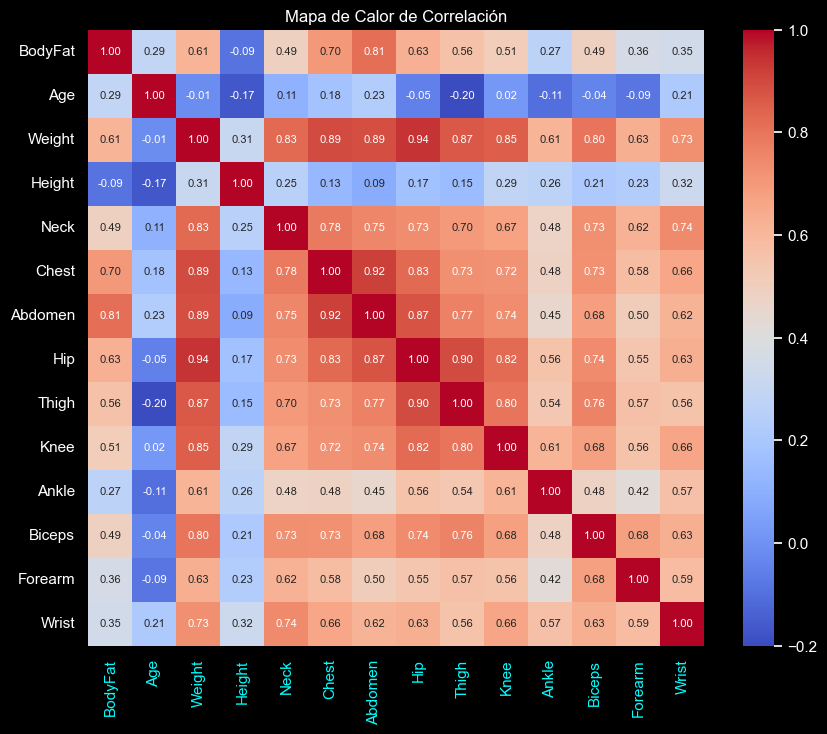

In [7]:
# Calcular la matriz de correlación
corr_matrix = df.corr()

# Configurar el tamaño de la figura
plt.figure(figsize=(10, 8))

# Crear el mapa de calor
sns.heatmap(corr_matrix, 
            annot=True,      # Para mostrar los valores de correlación
            cmap='coolwarm', # Escoger una paleta de colores
            cbar=True,       # Mostrar la barra de colores
            square=True,     # Hacer los cuadros del mapa cuadrados
            fmt='.2f',       # Formato de los números
            annot_kws={'size': 8})  # Tamaño de la fuente de los números

# Títulos y etiquetas
plt.title('Mapa de Calor de Correlación')
plt.yticks(rotation=0)  # Rotar las etiquetas del eje y
plt.xticks(rotation=90) # Rotar las etiquetas del eje x

# Mostrar gráfico
plt.show()


En el gráfico, podemos observar que la correlación entre algunas variables de entrada es bastante alto. Lo mejor sería filtrar las variables hasta no tener tanta intracorrelación:

In [8]:
df.drop(columns=['Height','Knee','Ankle','Wrist','Forearm'], inplace=True)

## Elección del Algoritmo

In [9]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate, KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Split de dataset
X = df.drop('BodyFat', axis=1)
y = df['BodyFat']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1)


# Entrenamiento del modelo
lr = LinearRegression()
lr.fit(X_train,y_train)
y_pred = lr.predict(X_test)


RANDOM FOREST

In [10]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

X = df.drop('BodyFat', axis=1)
y = df['BodyFat']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

random_forest_model = RandomForestRegressor(random_state=42)
random_forest_model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

Máquinas de Soporte Vectorial (SVM) para Regresión (SVR)

In [11]:
from sklearn.svm import SVR

X = df.drop('BodyFat', axis=1)
y = df['BodyFat']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

svr_model = SVR()
svr_model.fit(X_train, y_train)

y_pred = svr_model.predict(X_test)

## Métricas y Resultados

REGRESION LINEAL

In [12]:
# Métricas Regresion Lineal
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mse)
print(f"R-squared: {r2}")
print(f"Mean Squared Error: {mse}")
print(f"Mean Absolute Error: {mae}")
print(f"Root Mean Squared Error: {rmse}")

R-squared: 0.44688939155817853
Mean Squared Error: 25.729637986353527
Mean Absolute Error: 4.347817317818706
Root Mean Squared Error: 5.072439056938341


C:\Users\57311\AppData\Local\Temp\ipykernel_20704\2074049694.py:2: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2, color='red')  # Línea de ajuste perfecto


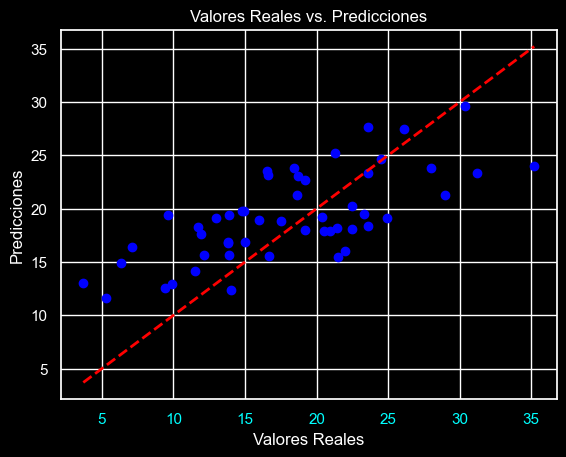

In [13]:
plt.scatter(y_test, y_pred, color='blue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2, color='red')  # Línea de ajuste perfecto
plt.xlabel('Valores Reales')
plt.ylabel('Predicciones')
plt.title('Valores Reales vs. Predicciones')
plt.show()

Random Forest

In [14]:
# Random Forest
from sklearn.metrics import mean_absolute_error, r2_score

y_pred = random_forest_model.predict(X_test)


mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error (MSE): {mse}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Coefficient of Determination (R²): {r2}")


Mean Squared Error (MSE): 17.4799154509804
Mean Absolute Error (MAE): 3.4783921568627467
Coefficient of Determination (R²): 0.624233863075289


C:\Users\57311\AppData\Local\Temp\ipykernel_20704\2074049694.py:2: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2, color='red')  # Línea de ajuste perfecto


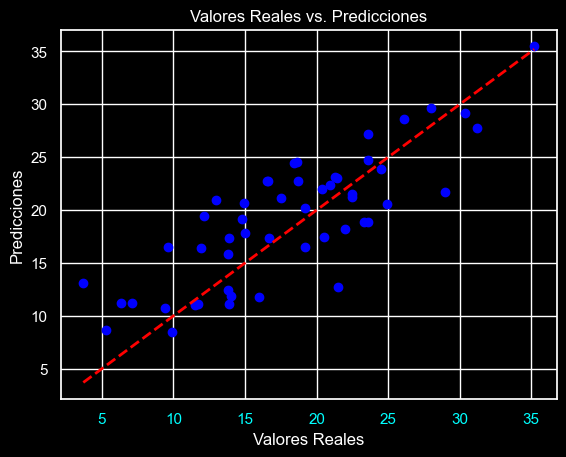

In [15]:
plt.scatter(y_test, y_pred, color='blue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2, color='red')  # Línea de ajuste perfecto
plt.xlabel('Valores Reales')
plt.ylabel('Predicciones')
plt.title('Valores Reales vs. Predicciones')
plt.show()

 Máquinas de Soporte Vectorial (SVM) para Regresión (SVR)

In [16]:
# Máquinas de Soporte Vectorial (SVM) para Regresión (SVR)

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error (MSE): {mse}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Coefficient of Determination (R²): {r2}")


Mean Squared Error (MSE): 17.4799154509804
Mean Absolute Error (MAE): 3.4783921568627467
Coefficient of Determination (R²): 0.624233863075289


C:\Users\57311\AppData\Local\Temp\ipykernel_20704\3936210103.py:2: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2, color='red')  # Línea de ajuste perfecto


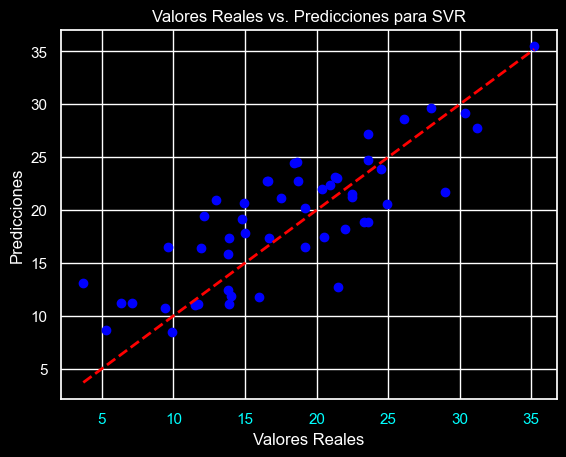

In [17]:
plt.scatter(y_test, y_pred, color='blue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2, color='red')  # Línea de ajuste perfecto
plt.xlabel('Valores Reales')
plt.ylabel('Predicciones')
plt.title('Valores Reales vs. Predicciones para SVR')
plt.show()

PIPELINE PARA COMPARAR MODELOS

In [18]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression

X = df.drop('BodyFat', axis=1)
y = df['BodyFat']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

models = [
    ('Linear Regression', LinearRegression()),
    ('Random Forest', RandomForestRegressor(random_state=42)),
    ('SVR', SVR())
]




In [19]:
for name, model in models:
    pipeline = Pipeline([
        ('scaler', StandardScaler()), 
        ('model', model)
    ])
    
    pipeline.fit(X_train, y_train)
    scores = cross_val_score(pipeline, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
    print(f"{name}: MSE = {-scores.mean()} (std = {scores.std()})")

Linear Regression: MSE = 23.074323973836528 (std = 4.087247305446669)
Random Forest: MSE = 25.681773352804875 (std = 3.3283799183434533)
SVR: MSE = 35.46048908975381 (std = 4.296223715599752)


## Conclusión y Reflexiones